## Linear Model

Start with packages

In [1]:
from math import prod, sqrt
import matplotlib.pyplot as plot
import numpy as np
import random
from random import gauss, randint, uniform
from sklearn.linear_model import LinearRegression
from statistics import mean

Set constants.

Set *masterSeed* to None to make every run different.  Set it to an integer to repeat to get 
the sam results over and over.

Sigma represents the amount of additive noise in the output.

In [2]:
nGene = 4
nSamp = 100

# masterSeed = 851  
masterSeed = None

sigma = 0.1

#### Set up the problem

The model assumes that of each gene:
1. Contributors something to the final output
2. That the contributions are additive.
3. That the contributions of each gene are independent of each other.

Writing this model as an algebraic shows that this is equivalent to assuming "the linear model".

In [3]:
if masterSeed is not None:
	seed = masterSeed
else:
	random.seed()
	seed = randint(0, 999)
	
random.seed(seed)
print(f'Seed = {seed}')

Seed = 207


In [4]:
nGene = 4

weightTrue = [uniform(-1,1) for _ in range(nGene)]
print(f'weights = {weightTrue}')

varName = ['x'+str(i) for i in range(nGene)]

weights = [0.011953333899681118, 0.3381304235283351, 0.7069638661032367, -0.5564007350486941]


Make a callable function for this model.

In [5]:
def LinMod(weights, inputs):
	assert(len(weights) == len(inputs))
	result = sum((weight*input for (weight,input) in zip(weights,inputs)))
	return result

Test the *LinMod* function

In [6]:
LinMod(weightTrue, (1,1,1,1)) - sum(weightTrue)

0.0

Assume that each gene (or perhaps SNIP) occurs in the population with a fixed proportion, not 
necessarily 1/2.

In [7]:
prev = [uniform(0,1) for _ in range(nGene)]
print(f'Prevalence = {prev}')

Prevalence = [0.15997528302862918, 0.6737426813866002, 0.34661343807210643, 0.6948884091173562]


Generate samples

In [8]:
geneSamp = tuple(tuple(uniform(0,1) < p for p in prev) for _ in range(nSamp))
print(f'1st sample = {geneSamp[0]}')
print(f'2nd sample = {geneSamp[1]}')

1st sample = (False, True, False, True)
2nd sample = (False, False, True, True)


In [9]:
geneNum = tuple(tuple(1 if hasGene else 0 for hasGene in samp) for samp in geneSamp)
print(f'1st sample = {geneNum[0]}')
print(f'2nd sample = {geneNum[1]}')

1st sample = (0, 1, 0, 1)
2nd sample = (0, 0, 1, 1)


Generate synthetic measurements

In [10]:
meas = tuple(LinMod(weightTrue, gn) + gauss(0,sigma) for gn in geneNum)
print(f'1st sample = {meas[0]}')
print(f'2nd sample = {meas[1]}')

1st sample = -0.29429870771412614
2nd sample = 0.21315027666164021


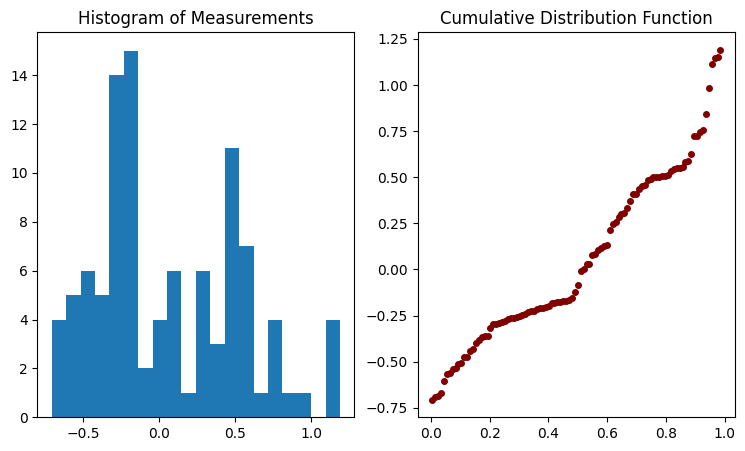

In [11]:
fig, (ax0,ax1) = plot.subplots(1,2, figsize=(9,5))

ax0.hist(meas,bins=20)
ax0.title.set_text('Histogram of Measurements')

x = [(k + 0.5)/(nSamp + 1) for k in range(nSamp)]
ax1.plot(x,sorted(meas), 'o', ms=4, c='maroon')
ax1.title.set_text('Cumulative Distribution Function')

#### Learn Module from (i.e., Fit Model to) the Data

In [12]:
x = np.array(geneNum)
y = np.array(meas)
print(f'x shape = {x.shape}, y shape = {y.shape}')

x shape = (100, 4), y shape = (100,)


In [13]:
reg = LinearRegression()
reg.fit(x,y)
weightFit = reg.coef_

In [14]:
nCase = 2 ** nGene
cases = tuple(tuple((num & (1 << bNum)) >> bNum for bNum in range(nGene)) for num in range(nCase))
cases

((0, 0, 0, 0),
 (1, 0, 0, 0),
 (0, 1, 0, 0),
 (1, 1, 0, 0),
 (0, 0, 1, 0),
 (1, 0, 1, 0),
 (0, 1, 1, 0),
 (1, 1, 1, 0),
 (0, 0, 0, 1),
 (1, 0, 0, 1),
 (0, 1, 0, 1),
 (1, 1, 0, 1),
 (0, 0, 1, 1),
 (1, 0, 1, 1),
 (0, 1, 1, 1),
 (1, 1, 1, 1))

In [15]:
prob = tuple(prod((p if g == 1 else (1 - p) for (p,g) in zip(prev,case))) for case in cases)

Check that the probabilites of the cases add to one

In [16]:
sum(prob)

1.0

In [17]:
noNoiseMeas = tuple(LinMod(weightTrue, case) for case in cases)
estMeas = tuple(LinMod(weightFit, case) for case in cases)

In [18]:
error = [(nnm - em, p) for (nnm,em,p) in zip(noNoiseMeas, estMeas, prob)]
error

[(0.0, 0.054636293844973295),
 (0.004473407628558914, 0.010404999275494937),
 (-0.016463600861508332, 0.11282751685873339),
 (-0.01199019323294942, 0.02148700339195907),
 (-0.03573127688680844, 0.02898387379937267),
 (-0.03125786925824947, 0.005519722599399105),
 (-0.05219487774831677, 0.059853593272798225),
 (-0.047721470119757914, 0.011398587839913148),
 (0.022173401338633103, 0.12443357920350177),
 (0.02664680896719207, 0.023697275388652614),
 (0.005709800477124771, 0.2569634718491674),
 (0.010183208105683683, 0.0489364221154111),
 (-0.013557875548175335, 0.06601046488021174),
 (-0.009084467919616368, 0.012571109621793619),
 (-0.030021476409683667, 0.13631592326261235),
 (-0.02554806878112481, 0.02596016279600559)]

The probability weighted mean RMS error

In [19]:
rmsErr = sqrt(mean(er*er*p for (er,p) in error))
rmsErr

0.005644286607225818

In [20]:
sigma/rmsErr

17.717030859485405

Only expected 10x improvement